In [45]:
import os
import pandas as pd
import numpy
import pickle
import pefile
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [7]:
"""
this file extracts the required information of a given file using the library PE 

"""

import pefile
import os
import array
import math
import pickle
from sklearn.externals import joblib
import sys
import argparse



def get_entropy(data):
    if len(data) == 0:
        return 0
    occurences = array.array('L', [0]*256)
    for x in data:
        occurences[x if isinstance(x, int) else ord(x)] += 1

    entropy = 0
    for x in occurences:
        if x:
            p_x = float(x) / len(data)
            entropy -= p_x*math.log(p_x, 2)

    return entropy


def get_resources(pe):
    """Extract resources :
    [entropy, size]"""
    resources = []
    if hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE'):
        try:
            for resource_type in pe.DIRECTORY_ENTRY_RESOURCE.entries:
                if hasattr(resource_type, 'directory'):
                    for resource_id in resource_type.directory.entries:
                        if hasattr(resource_id, 'directory'):
                            for resource_lang in resource_id.directory.entries:
                                data = pe.get_data(resource_lang.data.struct.OffsetToData, resource_lang.data.struct.Size)
                                size = resource_lang.data.struct.Size
                                entropy = get_entropy(data)

                                resources.append([entropy, size])
        except Exception as e:
            return resources
    return resources

def get_version_info(pe):
    """Return version infos"""
    res = {}
    for fileinfo in pe.FileInfo:
        if fileinfo.Key == 'StringFileInfo':
            for st in fileinfo.StringTable:
                for entry in st.entries.items():
                    res[entry[0]] = entry[1]
        if fileinfo.Key == 'VarFileInfo':
            for var in fileinfo.Var:
                res[var.entry.items()[0][0]] = var.entry.items()[0][1]
    if hasattr(pe, 'VS_FIXEDFILEINFO'):
        res['flags'] = pe.VS_FIXEDFILEINFO.FileFlags
        res['os'] = pe.VS_FIXEDFILEINFO.FileOS
        res['type'] = pe.VS_FIXEDFILEINFO.FileType
        res['file_version'] = pe.VS_FIXEDFILEINFO.FileVersionLS
        res['product_version'] = pe.VS_FIXEDFILEINFO.ProductVersionLS
        res['signature'] = pe.VS_FIXEDFILEINFO.Signature
        res['struct_version'] = pe.VS_FIXEDFILEINFO.StrucVersion
    return res

#extract the info for a given file
def extract_infos(fpath):
    res = {}
    pe = pefile.PE(fpath)
    res['Machine'] = pe.FILE_HEADER.Machine
    res['SizeOfOptionalHeader'] = pe.FILE_HEADER.SizeOfOptionalHeader
    res['Characteristics'] = pe.FILE_HEADER.Characteristics
    res['MajorLinkerVersion'] = pe.OPTIONAL_HEADER.MajorLinkerVersion
    res['MinorLinkerVersion'] = pe.OPTIONAL_HEADER.MinorLinkerVersion
    res['SizeOfCode'] = pe.OPTIONAL_HEADER.SizeOfCode
    res['SizeOfInitializedData'] = pe.OPTIONAL_HEADER.SizeOfInitializedData
    res['SizeOfUninitializedData'] = pe.OPTIONAL_HEADER.SizeOfUninitializedData
    res['AddressOfEntryPoint'] = pe.OPTIONAL_HEADER.AddressOfEntryPoint
    res['BaseOfCode'] = pe.OPTIONAL_HEADER.BaseOfCode
    try:
        res['BaseOfData'] = pe.OPTIONAL_HEADER.BaseOfData
    except AttributeError:
        res['BaseOfData'] = 0
    res['ImageBase'] = pe.OPTIONAL_HEADER.ImageBase
    res['SectionAlignment'] = pe.OPTIONAL_HEADER.SectionAlignment
    res['FileAlignment'] = pe.OPTIONAL_HEADER.FileAlignment
    res['MajorOperatingSystemVersion'] = pe.OPTIONAL_HEADER.MajorOperatingSystemVersion
    res['MinorOperatingSystemVersion'] = pe.OPTIONAL_HEADER.MinorOperatingSystemVersion
    res['MajorImageVersion'] = pe.OPTIONAL_HEADER.MajorImageVersion
    res['MinorImageVersion'] = pe.OPTIONAL_HEADER.MinorImageVersion
    res['MajorSubsystemVersion'] = pe.OPTIONAL_HEADER.MajorSubsystemVersion
    res['MinorSubsystemVersion'] = pe.OPTIONAL_HEADER.MinorSubsystemVersion
    res['SizeOfImage'] = pe.OPTIONAL_HEADER.SizeOfImage
    res['SizeOfHeaders'] = pe.OPTIONAL_HEADER.SizeOfHeaders
    res['CheckSum'] = pe.OPTIONAL_HEADER.CheckSum
    res['Subsystem'] = pe.OPTIONAL_HEADER.Subsystem
    res['DllCharacteristics'] = pe.OPTIONAL_HEADER.DllCharacteristics
    res['SizeOfStackReserve'] = pe.OPTIONAL_HEADER.SizeOfStackReserve
    res['SizeOfStackCommit'] = pe.OPTIONAL_HEADER.SizeOfStackCommit
    res['SizeOfHeapReserve'] = pe.OPTIONAL_HEADER.SizeOfHeapReserve
    res['SizeOfHeapCommit'] = pe.OPTIONAL_HEADER.SizeOfHeapCommit
    res['LoaderFlags'] = pe.OPTIONAL_HEADER.LoaderFlags
    res['NumberOfRvaAndSizes'] = pe.OPTIONAL_HEADER.NumberOfRvaAndSizes

    # Sections
    res['SectionsNb'] = len(pe.sections)
    entropy = list(map(lambda x:x.get_entropy(), pe.sections))
    res['SectionsMeanEntropy'] = sum(entropy)/float(len(entropy))
    res['SectionsMinEntropy'] = min(entropy)
    res['SectionsMaxEntropy'] = max(entropy)
    raw_sizes = list(map(lambda x:x.SizeOfRawData, pe.sections))
    res['SectionsMeanRawsize'] = sum(raw_sizes)/float(len(raw_sizes))
    res['SectionsMinRawsize'] = min(raw_sizes)
    res['SectionMaxRawsize'] = max(raw_sizes)
    virtual_sizes = list(map(lambda x:x.Misc_VirtualSize, pe.sections))
    res['SectionsMeanVirtualsize'] = sum(virtual_sizes)/float(len(virtual_sizes))
    res['SectionsMinVirtualsize'] = min(virtual_sizes)
    res['SectionMaxVirtualsize'] = max(virtual_sizes)

    #Imports
    try:
        res['ImportsNbDLL'] = len(pe.DIRECTORY_ENTRY_IMPORT)
        imports = sum([x.imports for x in pe.DIRECTORY_ENTRY_IMPORT], [])
        res['ImportsNb'] = len(imports)
        res['ImportsNbOrdinal'] = len(list(filter(lambda x:x.name is None, imports)))
    except AttributeError:
        res['ImportsNbDLL'] = 0
        res['ImportsNb'] = 0
        res['ImportsNbOrdinal'] = 0

    #Exports
    try:
        res['ExportNb'] = len(pe.DIRECTORY_ENTRY_EXPORT.symbols)
    except AttributeError:
        # No export
        res['ExportNb'] = 0
    #Resources
    resources= get_resources(pe)
    res['ResourcesNb'] = len(resources)
    if len(resources)> 0:
        entropy = list(map(lambda x:x[0], resources))
        res['ResourcesMeanEntropy'] = sum(entropy)/float(len(entropy))
        res['ResourcesMinEntropy'] = min(entropy)
        res['ResourcesMaxEntropy'] = max(entropy)
        sizes = list(map(lambda x:x[1], resources))
        res['ResourcesMeanSize'] = sum(sizes)/float(len(sizes))
        res['ResourcesMinSize'] = min(sizes)
        res['ResourcesMaxSize'] = max(sizes)
    else:
        res['ResourcesNb'] = 0
        res['ResourcesMeanEntropy'] = 0
        res['ResourcesMinEntropy'] = 0
        res['ResourcesMaxEntropy'] = 0
        res['ResourcesMeanSize'] = 0
        res['ResourcesMinSize'] = 0
        res['ResourcesMaxSize'] = 0

    # Load configuration size
    try:
        res['LoadConfigurationSize'] = pe.DIRECTORY_ENTRY_LOAD_CONFIG.struct.Size
    except AttributeError:
        res['LoadConfigurationSize'] = 0


    # Version configuration size
    try:
        version_infos = get_version_info(pe)
        res['VersionInformationSize'] = len(version_infos.keys())
    except AttributeError:
        res['VersionInformationSize'] = 0
    return res

## Загрузка данных

In [8]:
dataset = pd.read_csv('data.csv',sep='|', low_memory=False)
virus = dataset[dataset['legitimate'] == 0].drop(['Name','md5','legitimate'],axis=1)
virus['virus'] = 1
virus = virus.drop_duplicates()

In [9]:
from tqdm import tqdm_notebook
good_files = []
PATH = '../file_examples/normal_files/'
for file in tqdm_notebook(os.listdir(PATH)):
    data = extract_infos('../file_examples/normal_files/' + file)

    data_pd = pd.DataFrame(data=list(data.values())).T
    data_pd.columns = data.keys()
    good_files.append(data_pd)
good_files = pd.concat(good_files)
good_files['virus'] = 0

In [10]:
dataset = pd.concat([virus.sample(len(good_files)*4, random_state=42), good_files]).reset_index(drop=True)
dataset.groupby(dataset['virus']).size()

virus
0     87
1    348
dtype: int64

## Выбор моделей

In [33]:
models = {
    'RandomForest':RandomForestClassifier(n_estimators=50, max_depth=6, random_state=42),
    'ExtraTrees':ExtraTreesClassifier(n_estimators=40, max_depth=16, random_state=42),
    'kNN':KNeighborsClassifier(n_neighbors=50, p=4),
    'MLP':MLPClassifier(hidden_layer_sizes=(40,), activation='relu'),
    'LogReg':LogisticRegression(penalty='l1', C=10),
    'SGD':SGDClassifier(penalty='l1', random_state=42)
    
}
scores = dict.fromkeys(models.keys(), 0)
results = {}
results_std = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for key in tqdm_notebook(models.keys()):
    score = cross_val_score(models[key], dataset.drop('virus', axis=1),dataset['virus'], cv=cv)
    results[key] = score.mean()
    results_std[key] = score.std()

RandomForest 0.967839177663 0.0134063608363
ExtraTrees 0.979281791451 0.0087177282902
kNN 0.864460158927 0.0217313814613
MLP 0.624143398702 0.247601175907
LogReg 0.947041991689 0.0140898730054
SGD 0.566749289203 0.265557356798



<BarContainer object of 6 artists>

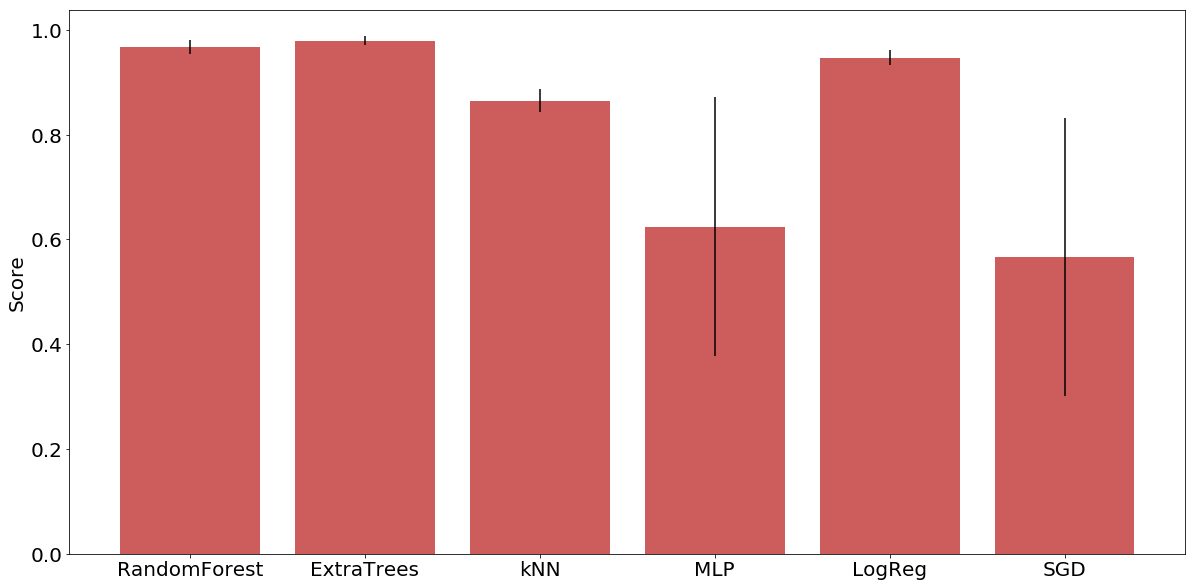

In [66]:
plt.figure(figsize=(20,10))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.ylabel('Score', size=20)
plt.bar(results.keys(), results.values(), yerr=results_std.values(), color='indianred')

In [56]:
from pprint import pprint
import operator
best_model = max(results.items(), key=operator.itemgetter(1))[0]

In [59]:
model = models[best_model]
model.fit(dataset.drop('virus', axis=1), dataset['virus'])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=16, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Отбор признаков

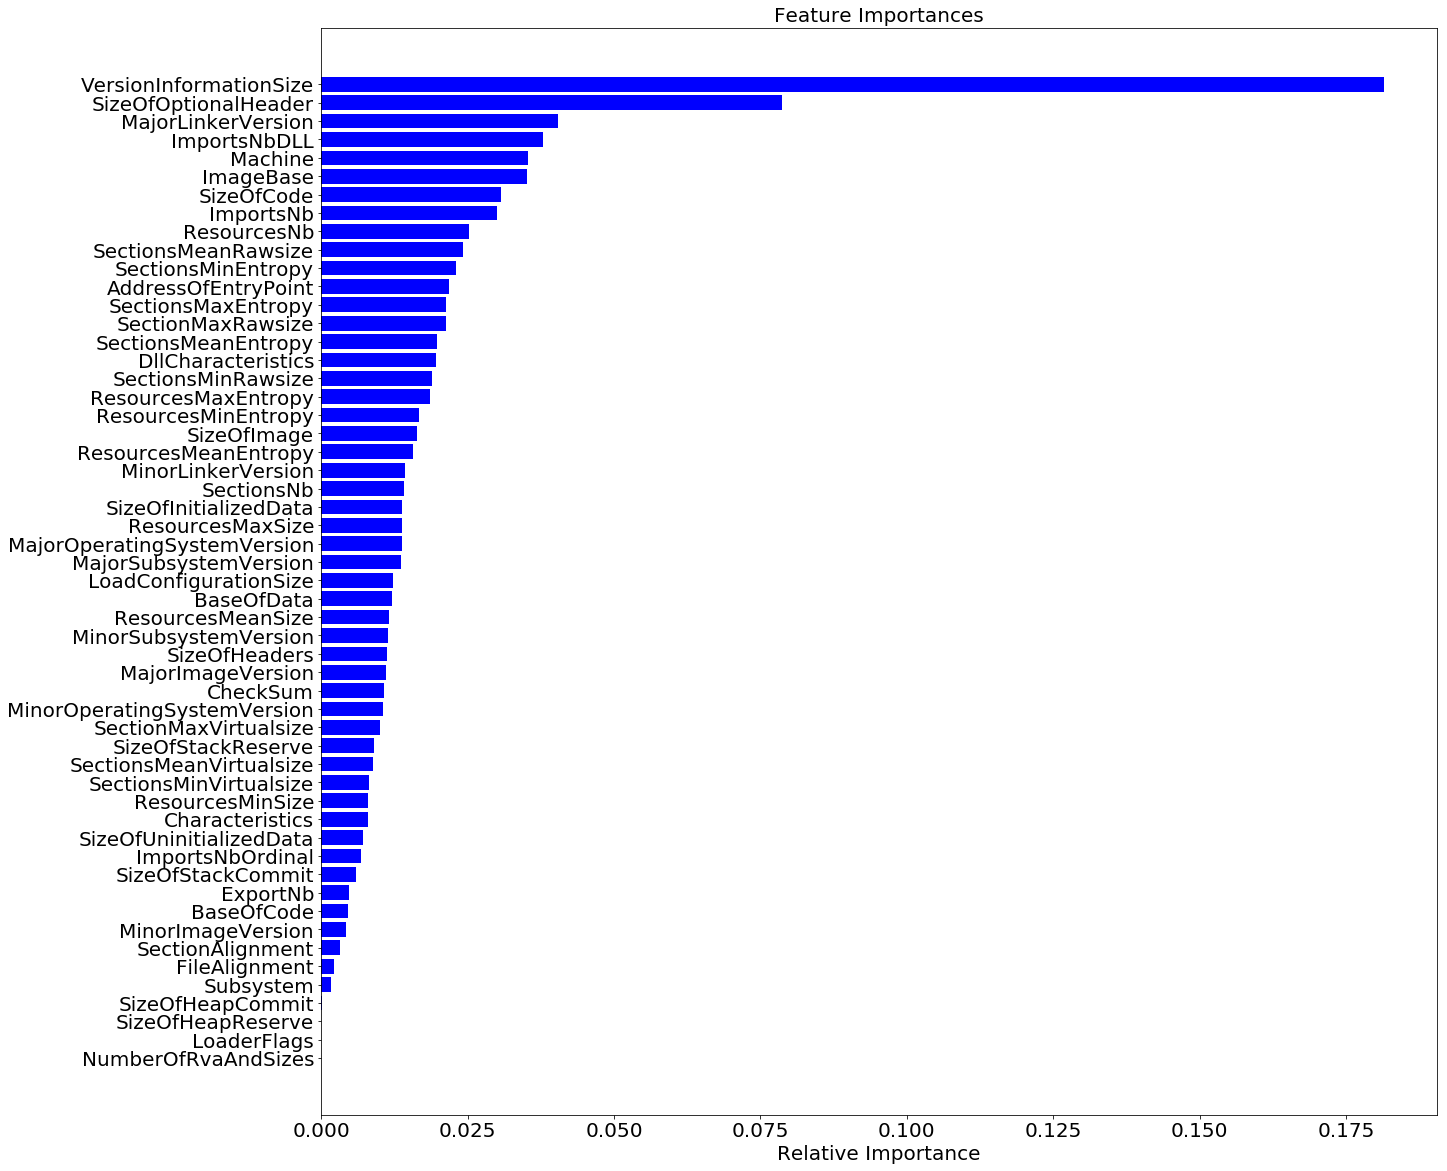

In [67]:
features = dataset.drop('virus', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,20))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title('Feature Importances', size=20)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', size=20)
plt.show()

In [75]:
use_features = []
results = []
for feature in tqdm_notebook(features[indices[::-1]]):
    use_features.append(feature)
    score = cross_val_score(models[best_model], dataset[use_features],dataset['virus'], cv=cv)
    results.append(score.mean())

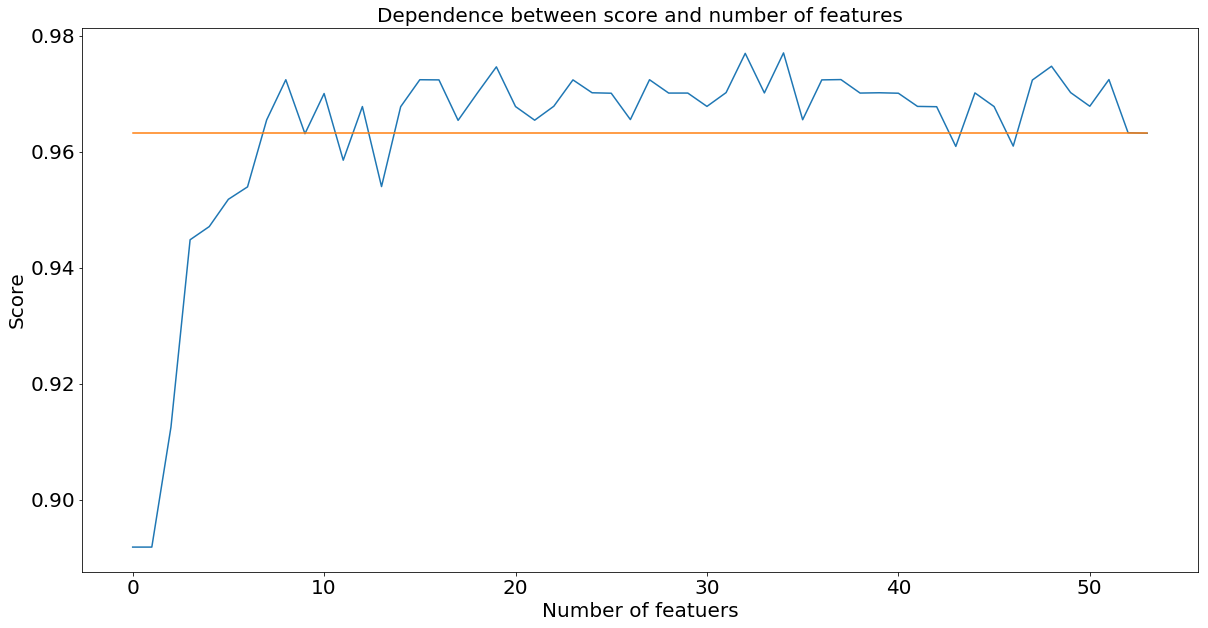

In [95]:
plt.figure(figsize=(20,10))
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.title('Dependence between score and number of features', size=20)
plt.ylabel('Score', size=20)
plt.xlabel('Number of featuers', size=20)
plt.plot(range(len(use_features)), results)
plt.plot(range(len(use_features)), [results[-1]]*len(use_features))

In [63]:
joblib.dump(model,'../best_classifier/classifier.pkl')

['../best_classifier/classifier.pkl']